## 워드임베딩
- Bow, Tfidf의 단점 : 단어사전의 길이에 맞춰 부피가 커진다
- 자연어처리에서는 선호하지 않음
- 압축된 수치 데이터로 만들어주는 워드임베딩을 활용함
- 학습을 통해서 각 단어가 가지고 있는 의미를 정교하게 실수로 표현 가능

## 데이터셋 구축

In [ ]:
# 말뭉치 생성
corpus = ['king is a strong man',
          'queen is a wise woman',
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is young queen',
          'man is strong',
         'prince is a boy will be king',
     'princess is a girl will be queen']

## 불용어 처리(stop words)

In [ ]:
def remove_stop_words(corpus) :
  stop_words = ['is', 'a', 'will', 'be'] #불용어 목록

  results = [] # 불용어 처리된 문장이 들어갈 리스트
  for text in corpus :
    temp = text.split(" ") # 토큰화
    for w in stop_words:
      if w in temp : # 토큰화된 리스트에 불용어가 있다면
        temp.remove(w) # 불용어 삭제
    results.append(" ".join(temp))
  return results # 결과물리턴

In [ ]:
corpus = remove_stop_words(corpus)
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'prince boy king',
 'princess girl queen']

## 단어사전 구축

In [ ]:
words = []

for text in corpus : # 전체문장반복
  for word in text.split(" "): # 각 문장에서 단어를 추출(토큰화)
    words.append(word)

words = set(words) # 집합을 이용해 중복제거
words

{'boy',
 'girl',
 'king',
 'man',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

In [ ]:
# 단어 인코딩
word2int = {} #key -> 단어, values -> 인덱스

for i,word in enumerate(words) :
  word2int[word] = i

In [ ]:
# 단어 토큰화
sentences = [] # 토큰화된 전체 문장이 담길 리스트

for sentence in corpus :
  sentences.append(sentence.split(" "))

In [ ]:
sentences

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [ ]:
# skip-gram 알고리즘

WINDOW_SIZE = 1 # 중심단어로부터 주변단어를 몇 개까지 볼껀지
data = [] # skip-gram 처리된 데이터가 들어갈 리스트

for s in sentences : # 전체 문장 반복
  for idx,word in enumerate(s): # 한 문장에서 각 던어들을 중심단어로 선정
  # 윈도우사이즈를 기반으로 중심단어로부터 주변단어 범위 찾기
    start = idx-WINDOW_SIZE
    if start < 0 :
      start = 0
    end = idx+WINDOW_SIZE
    if end >= len(s):
      end = len(s) - 1
    # 슬라이싱으로 주변단어 자르기
    for neighbor in s[start:end+1]:
      if neighbor != word : # 중심단어 자기자신 제거
        data.append([word,neighbor])

In [ ]:
import pandas as pd
df = pd.DataFrame(data, columns=["X","y"])

df

## 학습을 위한 인코딩(글자 -> 숫자) 작업

In [ ]:
X_train = [] # 중심단어
y_train = [] # 주변단어

for x,y in zip(df["X"],df["y"]) :
  X_train.append(word2int[x])
  y_train.append(word2int[y])

In [ ]:
print(X_train[:5])
print(y_train[:5])

[10, 7, 7, 9, 2]
[7, 10, 9, 7, 4]


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding


## 임베딩 모델구축

In [ ]:

embedding_model = Sequential() # 뼈대 생성
# 각 단어를 정교한 숫자로 학습하는 레이어
embedding_model.add(Embedding(11,2)) # (전체 단어토큰 수, 각 단어를 표현할 숫자의 수)
# 각 단어를 표현할 숫자의 수
# 너무 큰경우는 데이터 셋이 부족하면 만들어지는 숫자가 부실 함
# 너무 작은 경우는 각 단어의 의미를 충분히 반영하지 못하는 숫자가 됨
embedding_model.add(Dense(11, activation='softmax'))

In [ ]:
embedding_model.compile(loss="sparse_categorical_crossentropy",# 정답을 확률로 자동변경
                        optimizer="Adam",
                        metrics=['accuracy'])

In [ ]:
his = embedding_model.fit(np.array(X_train),
                          np.array(y_train),
                          epochs=3000)

In [32]:
embedding_vector = embedding_model.get_weights()[0]
embedding_vector

array([[ 0.45315805,  0.73475766],
       [ 1.8240099 ,  1.0557715 ],
       [ 0.9106028 ,  0.6992462 ],
       [-0.34550497, -0.514267  ],
       [-1.9940577 , -1.5144037 ],
       [-0.11710932,  0.9859442 ],
       [-0.02256097, -0.23699471],
       [ 2.213634  , -2.2195086 ],
       [ 0.7910318 , -0.3816495 ],
       [-0.21859987,  2.3057985 ],
       [-0.33107603,  1.4486125 ]], dtype=float32)

In [31]:
# 데이터프레임 만들기
w2v_df = pd.DataFrame(word2int.keys(),
                      index=word2int.values(),
                      columns=['word'])
w2v_df

,word
0,princess
1,woman
2,queen
3,young
4,wise
5,prince
6,girl
7,strong
8,boy
9,man


In [34]:
vector_df = pd.DataFrame(embedding_vector,
                         columns=['x1','x2'])
vector_df

,x1,x2
0,0.453158,0.734758
1,1.824010,1.055771
2,0.910603,0.699246
3,-0.345505,-0.514267
4,-1.994058,-1.514404
5,-0.117109,0.985944
6,-0.022561,-0.236995
7,2.213634,-2.219509
8,0.791032,-0.381649
9,-0.218600,2.305799


In [36]:
final_df = pd.concat([w2v_df, vector_df], axis=1)
final_df

,word,x1,x2
0,princess,0.453158,0.734758
1,woman,1.824010,1.055771
2,queen,0.910603,0.699246
3,young,-0.345505,-0.514267
4,wise,-1.994058,-1.514404
5,prince,-0.117109,0.985944
6,girl,-0.022561,-0.236995
7,strong,2.213634,-2.219509
8,boy,0.791032,-0.381649
9,man,-0.218600,2.305799


In [37]:
import matplotlib.pyplot as plt


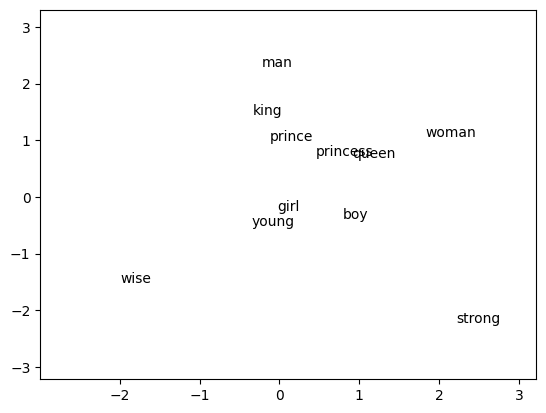

In [39]:
fig, ax = plt.subplots() # 그림판 생성
# 2차원 좌표공간에 각 단어를 표시
for word, x1, x2 in zip (final_df['word'], final_df['x1'], final_df['x2']) :
  ax.annotate(word,(x1,x2))

# x축, y축 범위 수정
# 학습된 가중치에서 x축, y축의 최소/최대 값 탐색
PADDING = 1.0
x_axis_min = np.amin(embedding_vector, axis=0)[0] - PADDING
y_axis_min = np.amin(embedding_vector, axis=0)[1] - PADDING
x_axis_max = np.amax(embedding_vector, axis=0)[0] + PADDING
y_axis_max = np.amax(embedding_vector, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)

plt.show()


In [ ]:
# word2vec을 구현한 라이브러리 사용하기

In [40]:
from gensim.models import Word2Vec
import pickle

In [41]:
%cd '/content/drive/MyDrive/Colab Notebooks/Ai_Deep_Learning'

/content/drive/MyDrive/Colab Notebooks/Ai_Deep_Learning


In [42]:
# 오픈할 파일명, 모드(읽기모드)
with open('./data/X_train_morphs.pkl','rb' )as f:
  X_train_morphs= pickle.load(f) # 파일로딩

In [43]:
w2v = Word2Vec(window=5, # 인접된 단어를 판별하는 범위 숫자
               min_count=5, # 전체 말뭉치에서 등장하는 최소 빈도 수
               sg=1, # skip-gram 방식으로 데이터 처리
               vector_size= 100, # 학습된 개별 단어가 가지는 숫자의 크기
               sentences=[doc.split(' ') for doc in X_train_morphs] # 학습데이터
               )

In [44]:
w2v.wv.get_vector('스파이더맨')

array([ 2.26852298e-01,  4.82995994e-02, -1.22121304e-01,  2.12273866e-01,
        1.14152916e-01,  2.48279292e-02,  1.66164711e-01,  4.13484424e-01,
       -1.15885794e-01, -1.41632125e-01, -3.12417626e-01,  1.74748003e-02,
       -3.37604403e-01, -2.75308281e-01,  3.34645025e-02, -2.06248745e-01,
       -7.02071637e-02, -7.23546296e-02, -2.27933805e-02, -1.06894478e-01,
       -4.47211228e-02,  1.47599488e-01, -3.64380074e-04, -1.07718356e-01,
        4.53573205e-02,  9.61783081e-02,  1.60740197e-01, -3.56307745e-01,
       -4.52549905e-01,  2.20969334e-01,  1.66498008e-04, -4.71728146e-01,
        2.00753286e-01, -2.51102656e-01, -2.47988045e-01,  3.26220810e-01,
       -3.50392610e-03, -3.64368677e-01, -2.00812310e-01, -5.90126395e-01,
       -3.22996378e-02, -1.94273397e-01,  1.42728746e-01, -3.57602797e-02,
        2.14356408e-01, -1.41584119e-02, -3.81518632e-01,  1.10384718e-01,
        1.34038776e-01, -9.14533138e-02,  4.03795168e-02, -4.41398948e-01,
       -4.17064250e-01,  

In [45]:
# 유사도 분석 기능
w2v.wv.most_similar('강동원')

[('황정민', 0.7843060493469238),
 ('안성기', 0.7782908082008362),
 ('베이컨', 0.7763881087303162),
 ('김민정', 0.7763386368751526),
 ('하지원', 0.7746232151985168),
 ('류덕환', 0.7742516994476318),
 ('유해진', 0.7721760869026184),
 ('정려원', 0.7703192830085754),
 ('이범수', 0.7702586650848389),
 ('이연희', 0.7702438235282898)]

## 임베딩 기법을 이용한 음악추천
https://kakao.github.io/recoteam/arena/melon

In [52]:
import json
from tqdm import tqdm

In [47]:
with open('./data/train.json', 'rb') as f:
  data = json.load(f)

In [ ]:
data

In [49]:
print(len(data
))

115071


In [53]:
play_list= []
for s in tqdm(data):
  songs = np.array(s['songs'], dtype='str') # 숫자타입 => 문자타입으로 변경
  play_list.append(list(songs)) # numpy에서 리스트타입으로 변경

100%|██████████| 115071/115071 [00:04<00:00, 23438.29it/s]


In [54]:
print(play_list[:3])

[['525514', '129701', '383374', '562083', '297861', '139541', '351214', '650298', '531057', '205238', '706183', '127099', '660493', '461973', '121455', '72552', '223955', '324992', '50104'], ['432406', '675945', '497066', '120377', '389529', '244277', '461062', '696302', '442765', '532114', '586541', '33389', '244000', '692078', '37741', '645653', '571802', '200183', '61435', '204499', '41749', '129258', '413920', '117205', '6546', '152422', '602724', '425946', '173634', '631268', '409869', '97749', '395416', '103741', '181101', '472144', '414721', '75801', '315216', '192882', '383960', '548636'], ['83116', '276692', '166267', '186301', '354465', '256598', '233195', '666852', '686560', '556426', '142974', '331878', '195141', '32017', '617795', '396532', '623704', '516930', '300104', '176874', '443513', '471385', '35784', '153029', '336743', '203558', '348801', '454550']]


In [56]:
w2v = Word2Vec(window=5, # 인접된 단어를 판별하는 범위 숫자
               min_count=5, # 전체 플레이리스트에서 등장하는 최소 빈도 수
               sg=1, # skip-gram 방식으로 데이터 처리
               vector_size= 50, # 학습된 개별 단어가 가지는 숫자의 크기
               sentences=play_list # 학습데이터
               )

## 음악 메타데이터 추출

In [57]:
with open('./data/song_meta.json', 'rb') as f:
  song_data = json.load(f)

In [59]:
id2song = {} # 노래 id에서 제목으로 변경하는 딕셔너리
for song in tqdm(song_data):
  id2song[song['id']] = song['song_name']

100%|██████████| 707989/707989 [00:01<00:00, 593788.19it/s]


In [60]:
id2song

{0: 'Feelings',
 1: 'Bach : Partita No. 4 In D Major, BWV 828 - II. Allemande',
 2: 'Solsbury Hill (Remastered 2002)',
 3: 'Feeling Right (Everything Is Nice) (Feat. Popcaan & Wale)',
 4: '그남자 그여자',
 5: 'Para Los Enamorados',
 6: 'Sibelius : Valse Triste Op.44 (시벨리우스 : 슬픈 왈츠 작품번호 44)',
 7: 'Superman March (From &#34;Superman&#34; / Live At Walt Disney Concert Hall, Los Angeles / 2019)',
 8: 'Lovers’ Leap (Feat. Qypthone)',
 9: '사랑, 그대라는 멜로디',
 10: 'Hi (Heyoo)',
 11: 'Everything We Do (2002 Digital Remaster)',
 12: 'So In Love',
 13: 'Voyage',
 14: 'Knock You Out',
 15: 'Faure: Romance Sans Paroles In A Flat Major Op.17 III.Andante.Moderato',
 16: 'Can&#39;t Stand Still',
 17: 'Girl Crush',
 18: 'ASMR 숙면과 휴식에 좋은 편안한 빗소리 (백색소음)',
 19: '무얼 기다리나 (Feat. 조원선)',
 20: 'IL MONDO (Sung by 길병민, 유채훈, 한기주) (‘팬텀싱어 3’ 유채훈 가창곡)',
 21: 'WHY',
 22: 'Hush, Hush, Sweet Charlotte',
 23: 'Anonymous: Up! Awake! From Highest Steeple - Arr. Jacob Praetorius (1586-1651)',
 24: 'As Long As I`m Alive (Radio Edit)

In [65]:
find_song_id = 508
rs = w2v.wv.most_similar(str(find_song_id)) # 유사한 노래 추출
print("검색할 노래 제목 : ",id2song[find_song_id])
for song_id, _ in rs:
  print(id2song[int(song_id)])

검색할 노래 제목 :  담배가게 아가씨
사랑이여
시를 위한 시(詩)
보이지 않는 사랑
이루어질 수 없는 사랑
인생은 미완성
너를 잊을 수 없어
내일이 찾아오면
빗물
아름다운 강산
한번만 더
